<a href="https://colab.research.google.com/github/souadkhailia/Clustering-for-Supervised-Learning/blob/main/Clustering_for_Supervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cluster Houses

In this project we will:

1. Cluster houses by neighborhood
2. Visualize the neighborhood clusters
3. Use neighborhood clusters as a new feature for predictive modeling
4. Compare model evaluation with and without clusters as a feature.



In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_squared_error, \
mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

# Useful Functions

In [2]:
def plot_2d_clusters(data, clusters, random_state=42):
  """Uses 2d data and number of clusters to fit a kmeans and plot the clusters"""

  # kmeans
  km = KMeans(n_clusters=clusters, random_state=random_state)
  km.fit(data)

  # plot clusters
  plt.figure(figsize=(10,8))
  plt.scatter( x=data.iloc[:,0], y=data.iloc[:,1], c=km.labels_,
          cmap = 'tab20', s=2)
  ticks = np.sort(np.unique(km.labels_))
  plt.xlabel(data.columns[0])
  plt.ylabel(data.columns[1])
  plt.colorbar(ticks=ticks)
  plt.show();

# Function to calculate and plot the silhouette score and inertia of a KMeans model for various values of k

def plot_k_values(data, ks, random_state=42):
  """plot the silhouette score and inertia
  of a KMeans model for various k values"""

  sils = []
  inertias = []

  for k in ks:
    km = KMeans(n_clusters=k, random_state=random_state)
    km.fit(data)
    sils.append(silhouette_score(data, km.labels_))
    inertias.append(km.inertia_)

  # plot inertia and silhouette score
  fig, axes = plt.subplots(2,1, figsize=(9,7))
  axes[0].set_xlabel('number of clusters')
  axes[0].set_ylabel('Inertia', color = 'blue')
  axes[0].plot(ks, inertias, color = 'blue', label='inertia', marker ='o')
  axes[0].grid()

  axes[1].plot(ks, sils, color = 'red', label='silhouette score', marker='+')
  axes[1].set_ylabel('Silhouette Score', color = 'red')
  axes[1].set_xlabel('Number of Clusters')
  axes[1].grid()

  # plt.grid()
  plt.show()

def evaluate_regression(y_true, y_pred, name='model'):
  scores = pd.DataFrame(index=['R2','MAE','RMSE'],
                        columns=[name])
  scores.loc['R2', name] = r2_score(y_true, y_pred)
  scores.loc['MAE', name] = mean_absolute_error(y_true, y_pred)
  scores.loc['RMSE', name] = np.sqrt(mean_squared_error(y_true, y_pred))
  return scores


In [3]:
# Load Data
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vT9qetZw-uGS1u44KiW-XOJJkhmX0BKPdcsQ_X9cwTHlsTvlBHbEyA5G_D8r9knBbPOQ7My-W4pTfy2/pub?gid=2140088293&single=true&output=csv')
df.head()

,price,rooms,bed,bath,car,land,lat,long
0,1480000,2,2,1,1,202,-37.7996,144.9984
1,1035000,2,2,1,0,156,-37.8079,144.9934
2,1465000,3,3,2,0,134,-37.8093,144.9944
3,850000,3,3,2,1,94,-37.7969,144.9969
4,1600000,4,3,1,2,120,-37.8072,144.9941


In [4]:
df.duplicated().sum()

22

In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17479 entries, 0 to 17500
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   17479 non-null  int64  
 1   rooms   17479 non-null  int64  
 2   bed     17479 non-null  int64  
 3   bath    17479 non-null  int64  
 4   car     17479 non-null  int64  
 5   land    17479 non-null  int64  
 6   lat     17479 non-null  float64
 7   long    17479 non-null  float64
dtypes: float64(2), int64(6)
memory usage: 1.2 MB


In [7]:
df.describe()

,price,rooms,bed,bath,car,land,lat,long
count,1.747900e+04,17479.000000,17479.000000,17479.000000,17479.000000,17479.000000,17479.000000,17479.000000
mean,1.061880e+06,3.041593,3.024544,1.571143,1.690028,592.575319,-37.806108,144.996018
std,5.601807e+05,0.936683,0.949957,0.688174,0.991686,3807.574687,0.089590,0.117446
min,8.500000e+04,1.000000,0.000000,0.000000,0.000000,0.000000,-38.190430,144.423790
25%,6.570000e+05,2.000000,2.000000,1.000000,1.000000,220.000000,-37.859200,144.924300
50%,9.100000e+05,3.000000,3.000000,1.000000,2.000000,512.000000,-37.798590,145.002430
75%,1.326000e+06,4.000000,4.000000,2.000000,2.000000,662.000000,-37.749000,145.067600
max,3.450000e+06,12.000000,20.000000,9.000000,18.000000,433014.000000,-37.399460,145.526350


In [8]:
df.corr()

,price,rooms,bed,bath,car,land,lat,long
price,1.000000,0.455858,0.437906,0.411467,0.184571,0.034332,-0.234614,0.223472
rooms,0.455858,1.000000,0.951651,0.595028,0.383878,0.033325,0.024515,0.092127
bed,0.437906,0.951651,1.000000,0.592157,0.385901,0.033284,0.024090,0.094530
bath,0.411467,0.595028,0.592157,1.000000,0.289946,0.037294,-0.045890,0.105813
car,0.184571,0.383878,0.385901,0.289946,1.000000,0.030421,0.008768,0.041522
land,0.034332,0.033325,0.033284,0.037294,0.030421,1.000000,0.024135,-0.004480
lat,-0.234614,0.024515,0.024090,-0.045890,0.008768,0.024135,1.000000,-0.346881
long,0.223472,0.092127,0.094530,0.105813,0.041522,-0.004480,-0.346881,1.000000


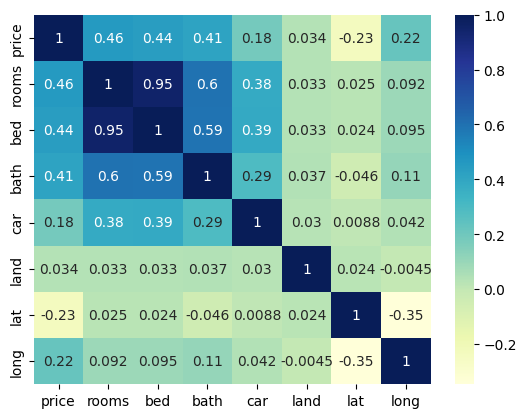

In [9]:
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)

# displaying heatmap
plt.show()

### Lets compare the location of the houses with their price.

We can do this with some beautiful graphics using Plotly's `scatter_mapbox()`, ([documentation](https://plotly.github.io/plotly.py-docs/generated/plotly.express.scatter_mapbox.html))

In [10]:
# Lets use plotly as cool way to show houses on a map
import plotly.express as px

px.scatter_mapbox(df, lat='lat', lon='long', color='price',
                  mapbox_style="open-street-map", width=1000, height=800)

#### To use our data for clustering we consider target is not known
- lets split the data and use it as unlabeled data (without target)


## Using KMeans Cluster for modeling by adding cluster as a feature in data

# Validation Split

In [11]:
# validation split
X = df.drop(columns = ['price'])
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [12]:
# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled[:5]

array([[ 1.01074389,  1.03025318,  2.09413656,  0.30811028,  0.02426676,
        -1.06448408,  0.3760452 ],
       [-1.10047275, -1.08204639, -0.82772007, -0.69287997, -0.10733684,
        -1.04007491,  0.51419986],
       [-1.10047275, -1.08204639,  0.63320824, -0.69287997, -0.13748193,
         0.4312244 ,  0.03138748],
       [-1.10047275, -1.08204639, -0.82772007,  0.30811028, -0.08146604,
         0.01165663, -0.92480401],
       [ 2.06635221,  2.08640297,  0.63320824,  0.30811028,  0.00357012,
         1.27778393,  0.721732  ]])

# Tune K

### Lets form a cluster based on only location (lat & long)

In [13]:
location = X_train[['lat','long']]

In [14]:
location

,lat,long
10351,-37.90087,145.03959
1733,-37.89870,145.05570
4334,-37.76790,144.99940
8263,-37.80520,144.88790
11508,-37.69264,145.07990
...,...,...
11301,-37.74650,144.86130
11983,-38.00765,145.09350
5398,-37.74150,145.07260
860,-37.91910,145.07500


## Tune K Using Only Location Data

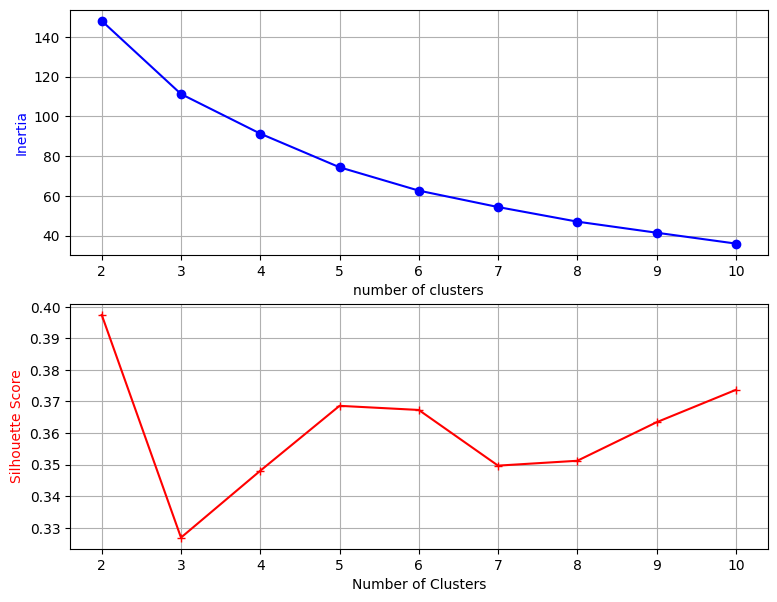

In [15]:
# Silhouette and Inertia Plots
plot_k_values(location, ks=range(2,11), random_state=42)

- No clear elbow
- Silhouette score is high for k =2 and 11
- we will try first no of clusters = 11 and then for the highest score of 2


## Plot 2 Clusters

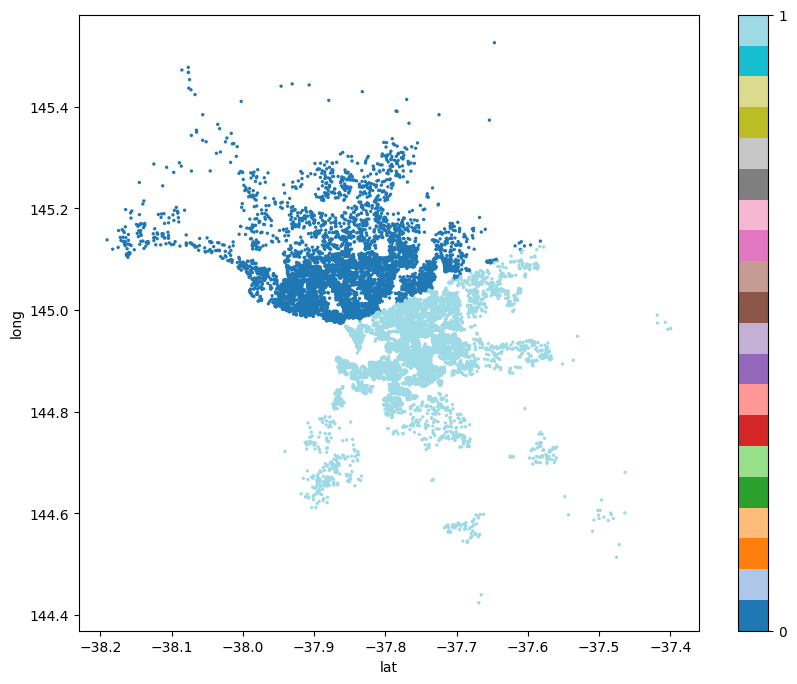

In [16]:
# Scatter Plot of Neighborhood in 2 Clusters
plot_2d_clusters(location, 2)

# Plot 5 clusters

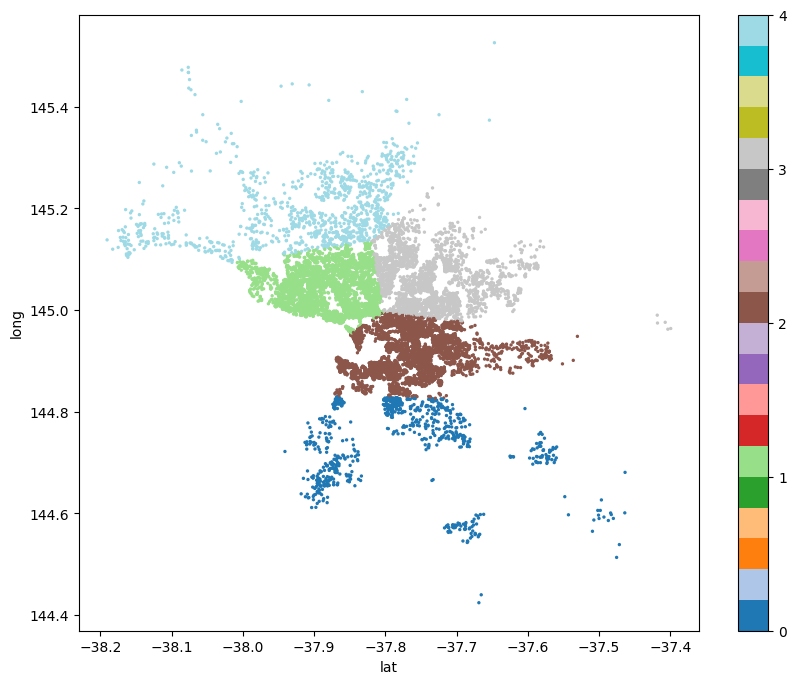

In [17]:
# Scatter Plot of Neighborhoods in 5 clusters
plot_2d_clusters(location, 5)

# Modeling

## Linear Regression Baseline without Clusters

In [18]:
# Without clusters
model = LinearRegression()
model.fit(X_train_scaled, y_train)

train_scores = evaluate_regression(y_train, model.predict(X_train_scaled), name='train')
test_scores = evaluate_regression(y_test, model.predict(X_test_scaled), name='test')

pd.concat([train_scores, test_scores], axis=1)

,train,test
R2,0.309684,0.283276
MAE,351908.911096,351556.654281
RMSE,468619.703689,466385.269764


## Linear Regression Model with Clustering as Feature Extraction



## 2 clusters

In [19]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_train.columns)

In [20]:
X_test_scaled

,rooms,bed,bath,car,land,lat,long
0,-1.100473,-1.082046,-0.827720,-1.693870,-0.111611,-0.512522,0.063975
1,1.010744,1.030253,0.633208,9.317023,0.019318,0.563731,-1.663258
2,-2.156081,-2.138196,-0.827720,-0.692880,-0.137482,-0.533894,0.134296
3,-0.044864,-0.025897,-0.827720,-0.692880,-0.078991,1.684528,0.680054
4,-0.044864,-0.025897,-0.827720,0.308110,-0.036473,0.873289,-0.429986
...,...,...,...,...,...,...,...
5239,1.010744,1.030253,0.633208,1.309101,-0.042997,-0.680124,-0.107539
5240,-0.044864,-0.025897,-0.827720,0.308110,-0.044797,1.202869,0.567627
5241,-1.100473,-1.082046,-0.827720,-0.692880,0.029666,-0.753239,-1.564466
5242,-1.100473,-1.082046,-0.827720,1.309101,-0.090915,0.098270,-0.945386


In [21]:
# Let's see what adding the Kmeans clusters does!

# make copies of the data to add cluster feature to
X_train_clusters2 = X_train_scaled.copy()
X_test_clusters2 = X_test_scaled.copy()
X_test_clusters2

,rooms,bed,bath,car,land,lat,long
0,-1.100473,-1.082046,-0.827720,-1.693870,-0.111611,-0.512522,0.063975
1,1.010744,1.030253,0.633208,9.317023,0.019318,0.563731,-1.663258
2,-2.156081,-2.138196,-0.827720,-0.692880,-0.137482,-0.533894,0.134296
3,-0.044864,-0.025897,-0.827720,-0.692880,-0.078991,1.684528,0.680054
4,-0.044864,-0.025897,-0.827720,0.308110,-0.036473,0.873289,-0.429986
...,...,...,...,...,...,...,...
5239,1.010744,1.030253,0.633208,1.309101,-0.042997,-0.680124,-0.107539
5240,-0.044864,-0.025897,-0.827720,0.308110,-0.044797,1.202869,0.567627
5241,-1.100473,-1.082046,-0.827720,-0.692880,0.029666,-0.753239,-1.564466
5242,-1.100473,-1.082046,-0.827720,1.309101,-0.090915,0.098270,-0.945386


In [22]:
# create subset of data with only latitude and longitude
location_train = X_train_scaled[['lat','long']]
location_test = X_test_scaled[['lat','long']]
location_test

,lat,long
0,-0.512522,0.063975
1,0.563731,-1.663258
2,-0.533894,0.134296
3,1.684528,0.680054
4,0.873289,-0.429986
...,...,...
5239,-0.680124,-0.107539
5240,1.202869,0.567627
5241,-0.753239,-1.564466
5242,0.098270,-0.945386


In [23]:
# fit a kmeans model on just the training location data
km = KMeans(n_clusters=2, random_state=42)
km.fit(location_train)

# add clusters as a new feature in the training and testing
X_train_clusters2['cluster'] = km.predict(location_train)
X_test_clusters2['cluster'] = km.predict(location_test)

# create a new model to fit on the data with the cluster feature

model.fit(X_train_clusters2, y_train)


# evaluate the new model on the training and testing data
train_scores = evaluate_regression(y_train, model.predict(X_train_clusters2), name='Train')
test_scores = evaluate_regression(y_test, model.predict(X_test_clusters2), name='Test')

# combine the training and testing scores into one dataframe
pd.concat([train_scores, test_scores], axis=1)


,Train,Test
R2,0.333387,0.306633
MAE,350964.571617,350615.490087
RMSE,460504.278763,458722.764272


In [24]:
 X_train_clusters2

,rooms,bed,bath,car,land,lat,long,cluster
0,1.010744,1.030253,2.094137,0.308110,0.024267,-1.064484,0.376045,0
1,-1.100473,-1.082046,-0.827720,-0.692880,-0.107337,-1.040075,0.514200,0
2,-1.100473,-1.082046,0.633208,-0.692880,-0.137482,0.431224,0.031387,1
3,-1.100473,-1.082046,-0.827720,0.308110,-0.081466,0.011657,-0.924804,1
4,2.066352,2.086403,0.633208,0.308110,0.003570,1.277784,0.721732,1
...,...,...,...,...,...,...,...,...
12230,-0.044864,-0.025897,-0.827720,-0.692880,-0.009703,0.671942,-1.152918,1
12231,-1.100473,-1.082046,-0.827720,-0.692880,-0.137482,-2.265595,0.838362,0
12232,-0.044864,-0.025897,0.633208,0.308110,-0.099463,0.728184,0.659129,1
12233,2.066352,2.086403,0.633208,0.308110,0.026516,-1.269544,0.679711,0


## 5 clusters

In [25]:
# Let's see what adding the Kmeans clusters does!

# make copies of the data to add cluster feature to
X_train_clusters5 = X_train_scaled.copy()
X_test_clusters5 = X_test_scaled.copy()

# create subset of data with only latitude and longitude
location_train = X_train_scaled[['lat','long']]
location_test = X_test_scaled[['lat','long']]

# fit a kmeans model on just the training location data
km = KMeans(n_clusters=7, random_state=42)
km.fit(location_train)

# add clusters as a new feature in the training and testing
X_train_clusters5['cluster'] = km.predict(location_train)
X_test_clusters5['cluster'] = km.predict(location_test)

# create a new model to fit on the data with the cluster feature
lr = LinearRegression()

model.fit(X_train_clusters5, y_train)


# evaluate the new model on the training and testing data
train_scores = evaluate_regression(y_train, model.predict(X_train_clusters5), name='Train')
test_scores = evaluate_regression(y_test, model.predict(X_test_clusters5), name='Test')

# combine the training and testing scores into one dataframe
pd.concat([train_scores, test_scores], axis=1)

,Train,Test
R2,0.428029,0.426238
MAE,320088.775443,312920.096552
RMSE,426563.377221,417286.734499


In [26]:
ks = range(2,12)
X_train_cluster = X_train_scaled.copy()
X_test_cluster = X_test_scaled.copy()

scores = pd.DataFrame()
for k in ks:
  km = KMeans(n_clusters=k, random_state=42)
  km.fit(location_train)

  X_train_cluster['cluster'] = km.predict(location_train)
  X_test_cluster['cluster'] = km.predict(location_test)

  model = LinearRegression()
  model.fit(X_train_cluster, y_train)

  train_scores = evaluate_regression(y_train, model.predict(X_train_cluster), name='train')
  test_scores = evaluate_regression(y_test, model.predict(X_test_cluster), name='test')
  k_scores = pd.concat([train_scores, test_scores], axis=1)
  k_scores['k'] = k
  k_scores.reset_index()
  scores = scores.append(k_scores)

In [27]:
scores

,train,test,k
R2,0.333387,0.306633,2
MAE,350964.571617,350615.490087,2
RMSE,460504.278763,458722.764272,2
R2,0.314788,0.288613,3
MAE,349886.529702,350758.747813,3
RMSE,466884.326423,464645.646093,3
R2,0.376551,0.361755,4
MAE,334413.549183,330277.311427,4
RMSE,445345.710554,440111.399147,4
R2,0.317191,0.292133,5


# Results

Our neighborhood clusters improved our model performance!